#Time Series Analysis for Food Delivery

##Import libraries

In [4]:
# 1. Setup environment
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn tensorflow

# 2. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout



##Load Dataset

In [5]:
# 3. Load dataset
df = pd.read_csv('/content/orders_autumn_2020.csv')
df

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
0,2020-08-01 06:07:00.000,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0
1,2020-08-01 06:17:00.000,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0
2,2020-08-01 06:54:00.000,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0
3,2020-08-01 07:09:00.000,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0
4,2020-08-01 07:10:00.000,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18701,2020-09-30 19:27:00.000,-1,1,60.170,24.946,60.170,24.945,24,23,0.0,12.8,2.34419,0.0
18702,2020-09-30 19:36:00.000,-8,6,60.185,24.944,60.178,24.949,23,15,0.0,12.8,2.34419,0.0
18703,2020-09-30 19:39:00.000,-14,3,60.186,24.949,60.188,24.956,25,11,0.0,12.8,2.34419,0.0
18704,2020-09-30 19:42:00.000,-11,3,60.172,24.929,60.168,24.930,21,10,0.0,12.8,2.34419,0.0


## 4. Parse 'timestamp' column to datetime format

In [6]:

# 4. Parse 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['TIMESTAMP'])

# Sort by timestamp and set it as index
df = df.sort_values('timestamp').set_index('timestamp')

# Resample data by hour: count number of orders per hour
df = df.resample('H').size().rename('orders').to_frame()

# Fill any missing hours with zero orders
df['orders'].fillna(0, inplace=True)


/tmp/ipython-input-6-1208704366.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').size().rename('orders').to_frame()
/tmp/ipython-input-6-1208704366.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['orders'].fillna(0, inplace=True)


## 5. Plot time series

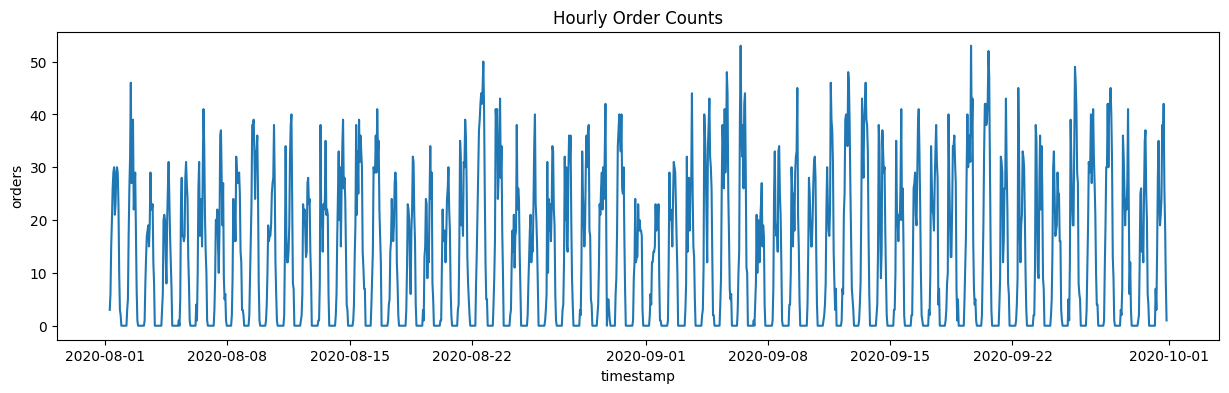

In [7]:

plt.figure(figsize=(15,4))
sns.lineplot(data=df['orders'])
plt.title('Hourly Order Counts')
plt.show()


## 6. Decompose series

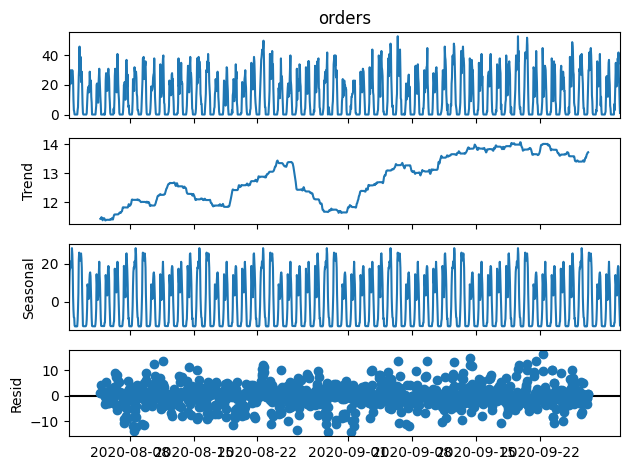

In [8]:

# 6. Decompose series
decomp = seasonal_decompose(df['orders'], model='additive', period=24*7)
decomp.plot()
plt.show()



## 7. Train‑test split


In [9]:
train = df.iloc[:-168]  # last week as test
test  = df.iloc[-168:]



## 8. Forecast with ETS (Holt-Winters)

In [10]:

ets = ExponentialSmoothing(train['orders'], seasonal='add', seasonal_periods=24*7).fit()
pred_ets = ets.forecast(len(test))
print('ETS RMSE:', np.sqrt(mean_squared_error(test['orders'], pred_ets)))


ETS RMSE: 4.060495540716597


## 9. Forecast with ARIMA


In [11]:

arima = ARIMA(train['orders'], order=(2,1,2), seasonal_order=(1,1,1,24)).fit()
pred_arima = arima.forecast(len(test))
print('ARIMA RMSE:', np.sqrt(mean_squared_error(test['orders'], pred_arima)))


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA RMSE: 5.120413777744434


## 10. Prepare LSTM dataset


In [12]:

def create_supervised(series, n_steps=24):
    X, y = [], []
    for i in range(len(series)-n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 24
series = df['orders'].values
X, y = create_supervised(series, n_steps)
split = len(X) - 168
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



## 11. Build LSTM model

In [13]:

model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps,1)),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_test, y_test), verbose=2)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
40/40 - 3s - 74ms/step - loss: 347.4836 - val_loss: 67.6984
Epoch 2/20
40/40 - 1s - 13ms/step - loss: 65.0259 - val_loss: 47.3559
Epoch 3/20
40/40 - 1s - 15ms/step - loss: 49.1902 - val_loss: 39.6645
Epoch 4/20
40/40 - 0s - 12ms/step - loss: 47.2028 - val_loss: 35.3230
Epoch 5/20
40/40 - 1s - 13ms/step - loss: 43.8363 - val_loss: 28.3277
Epoch 6/20
40/40 - 1s - 15ms/step - loss: 41.0380 - val_loss: 31.3747
Epoch 7/20
40/40 - 1s - 16ms/step - loss: 39.0426 - val_loss: 29.9305
Epoch 8/20
40/40 - 0s - 12ms/step - loss: 39.2665 - val_loss: 27.8128
Epoch 9/20
40/40 - 1s - 16ms/step - loss: 35.1973 - val_loss: 26.2287
Epoch 10/20
40/40 - 0s - 12ms/step - loss: 36.6376 - val_loss: 32.4219
Epoch 11/20
40/40 - 1s - 15ms/step - loss: 32.8439 - val_loss: 31.0560
Epoch 12/20
40/40 - 1s - 17ms/step - loss: 32.3658 - val_loss: 24.1094
Epoch 13/20
40/40 - 1s - 32ms/step - loss: 32.3117 - val_loss: 29.8002
Epoch 14/20
40/40 - 1s - 18ms/step - loss: 32.6984 - val_loss: 31.7917
Epoch 15/20
40

## 12. Predict and evaluate LSTM


In [14]:
y_pred = model.predict(X_test).flatten()
print('LSTM RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
LSTM RMSE: 4.6762183167567875


## 13. Plot predictions

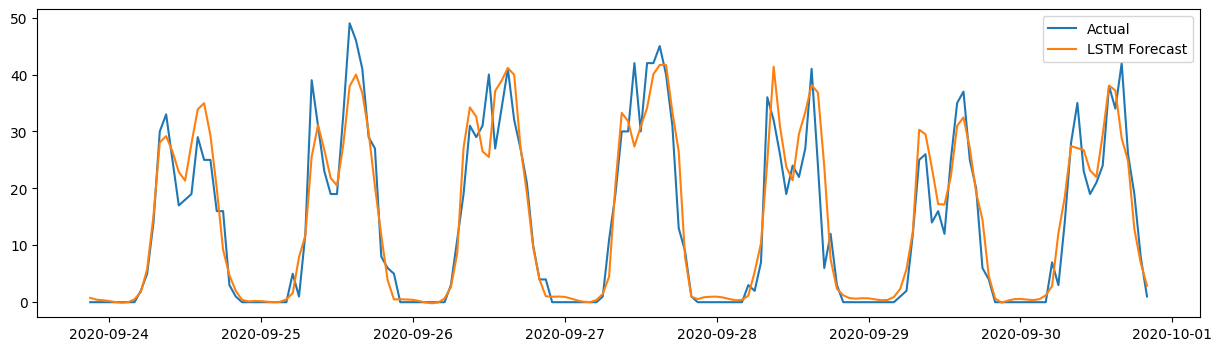

In [15]:

plt.figure(figsize=(15,4))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, y_pred, label='LSTM Forecast')
plt.legend()
plt.show()


## 13.1 Build BiLSTM model

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 - 4s - 108ms/step - loss: 149.6144 - val_loss: 37.6916
Epoch 2/20
40/40 - 1s - 22ms/step - loss: 40.9198 - val_loss: 31.0693
Epoch 3/20
40/40 - 2s - 43ms/step - loss: 39.4090 - val_loss: 28.8493
Epoch 4/20
40/40 - 1s - 30ms/step - loss: 35.3623 - val_loss: 28.0656
Epoch 5/20
40/40 - 1s - 31ms/step - loss: 36.2711 - val_loss: 40.0094
Epoch 6/20
40/40 - 1s - 19ms/step - loss: 35.2056 - val_loss: 26.3626
Epoch 7/20
40/40 - 1s - 30ms/step - loss: 32.6704 - val_loss: 29.4500
Epoch 8/20
40/40 - 1s - 31ms/step - loss: 31.1965 - val_loss: 26.9125
Epoch 9/20
40/40 - 1s - 31ms/step - loss: 30.0041 - val_loss: 23.8025
Epoch 10/20
40/40 - 1s - 17ms/step - loss: 31.0634 - val_loss: 29.4830
Epoch 11/20
40/40 - 1s - 17ms/step - loss: 30.9302 - val_loss: 25.7895
Epoch 12/20
40/40 - 1s - 17ms/step - loss: 30.6660 - val_loss: 25.1494
Epoch 13/20
40/40 - 1s - 17ms/step - loss: 29.2437 - val_loss: 24.1587
Epoch 14/20
40/40 - 1s - 17ms/step - loss: 28.0261 - val_loss: 24.0667
Epoch 15/20
40/40 - 1s -

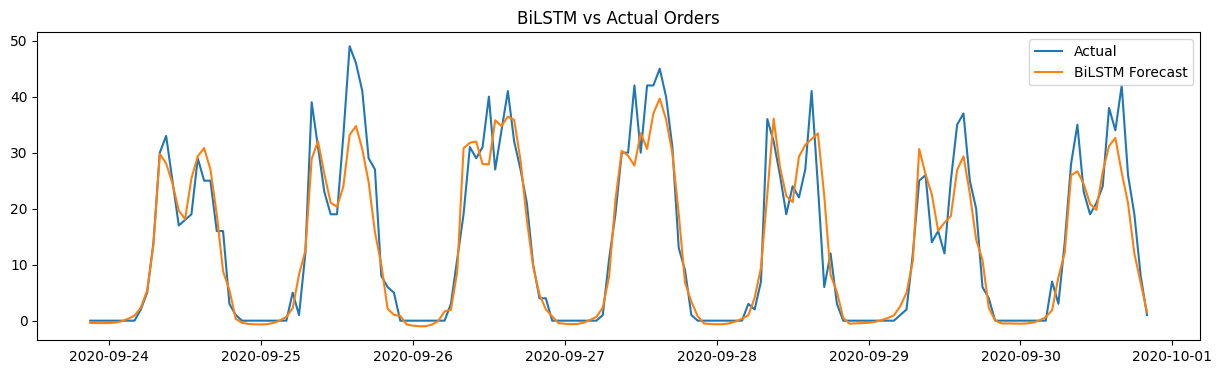

In [16]:
from tensorflow.keras.layers import Bidirectional
####################################################################

bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, 1)),
    Dropout(0.2),
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# 13.2 Train BiLSTM
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32,
                 validation_data=(X_test, y_test), verbose=2)

# 13.3 Predict with BiLSTM
y_pred_bilstm = bilstm_model.predict(X_test).flatten()

# 13.4 Evaluate BiLSTM
rmse_bilstm = np.sqrt(mean_squared_error(y_test, y_pred_bilstm))
print('BiLSTM RMSE:', rmse_bilstm)

# 13.5 Plot BiLSTM predictions
plt.figure(figsize=(15,4))
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, y_pred_bilstm, label='BiLSTM Forecast')
plt.legend()
plt.title('BiLSTM vs Actual Orders')
plt.show()



### 14. Model comparison summary

In [17]:
# 14. Model comparison summary
results = pd.DataFrame({
    'Model': ['ETS', 'ARIMA', 'LSTM', 'BiLSTM'],
    'RMSE': [
        np.sqrt(mean_squared_error(test['orders'], pred_ets)),
        np.sqrt(mean_squared_error(test['orders'], pred_arima)),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        rmse_bilstm
    ]
})

results


,Model,RMSE
0,ETS,4.060496
1,ARIMA,5.120414
2,LSTM,4.676218
3,BiLSTM,4.677935
